In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,class_likelihood_ratios
import pydot # it needs Graphviz to be installed as well
import clean
import datetime
from matplotlib import pyplot as plt



In [4]:
#variables used for the creation of the corpus and the configuration of the model
ProjConfig = {
  'under_sample': True, #use undersampling of Shakespeare corpus sentences
  'under_sampling_weight': 100, #the number of sentences added to the other author's median
  'over_sample': False, #use overersampling for Marlowe corpus sentences
  'over_sampling_fraction': 2, #fraction of the corpus used for oversampling
  'batch_size': 16,  #number of batches for the creation of datasets
  'epochs': 6, #number of epochs for the training of the model
  'max_seq_len': 16, #sets the maximum sentence length to a value close to the median sentence length of the corpus (BERT max is 512)
  'learning_rate': 4e-5, #sets the learning rate for ADAM optimizer
  'decay_factor': 0.0001,
  'cycles': 6
}

In [5]:
if 'COLAB_TPU_ADDR' in os.environ:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU


In [6]:
def importPlaysinCorpus(CorpusPath,Author):
    """Imports plays in text form to the corpus dataframe (preferable cleaned)"""
    corpus=pd.DataFrame()
    for play in os.scandir(CorpusPath):
        if play.is_file():
            print((" importing  ") + (play.path) + (" to corpus"))
            newplay=pd.read_csv(play.path, delimiter='\r', header=None, names=['sentence', 'author', 'play'])
            newplay[['author']]=Author
            if 'Cleaned' in play.path:
                newplay[['play']]=os.path.basename(play.path).removesuffix('Cleaned.txt')
            else:
                newplay[['play']]=os.path.basename(play.path).removesuffix('.txt')
            corpus=pd.concat([corpus, newplay], axis = 0,join='outer')
    return corpus

In [7]:
projectCorpus=pd.DataFrame()
MarlowePath='./Corpus/Marlowe/'
ShakespearePath='./Corpus/Shakespeare/CleanedPlays/'

projectCorpus=importPlaysinCorpus(MarlowePath,'Marlowe')
projectCorpus=projectCorpus.append(importPlaysinCorpus(ShakespearePath,'Shakespeare'))
projectCorpus['sentence']=projectCorpus['sentence'].str.lower()
NewProjectCorpus=projectCorpus

 importing  ./Corpus/Marlowe/Dido.txt to corpus
 importing  ./Corpus/Marlowe/DrFaustus.txt to corpus
 importing  ./Corpus/Marlowe/EdwardII.txt to corpus
 importing  ./Corpus/Marlowe/JewOfMalta.txt to corpus
 importing  ./Corpus/Marlowe/Tamburlaine1.txt to corpus
 importing  ./Corpus/Marlowe/Tamburlaine2.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/AnthonyCleopatraCleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/HenryVIIICleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/HenryVCleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/MacbethCleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/RichardIIICleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/HamletCleaned.txt to corpus


C:\Users\Panos\AppData\Local\Temp\ipykernel_7652\3063647115.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  projectCorpus=projectCorpus.append(importPlaysinCorpus(ShakespearePath,'Shakespeare'))


Over and under sampling corpus

In [8]:
if ProjConfig['over_sample']==True:
    ShakespeareMedian=projectCorpus.loc[projectCorpus['author'] == 'Shakespeare'].play.value_counts().median()
    MarloweCorpusAddition=pd.DataFrame()
    for play in projectCorpus.loc[projectCorpus['author'] == 'Marlowe'].play.unique():
        selectedPlay=projectCorpus.loc[projectCorpus['play'] == play] 
        if selectedPlay.value_counts().sum() < ShakespeareMedian:
            selecteplaySample=selectedPlay.sample(int(selectedPlay['sentence'].value_counts().sum()/ProjConfig['over_sampling_fraction']))
            MarloweCorpusAddition=pd.concat([MarloweCorpusAddition,selecteplaySample])
            print('adding a sample from ', play, 'to Marlowe\'s corpus')
    #adding a fraction of Marlowe's corpus to increase its volume
    NewProjectCorpus=pd.concat([projectCorpus, MarloweCorpusAddition], axis = 0,join='outer')

In [9]:
if ProjConfig['under_sample']==True:
    ShakespeareMedian=projectCorpus.loc[projectCorpus['author'] == 'Shakespeare'].play.value_counts().median()
    NewShakesepareCorpus=pd.DataFrame()
    MarloweMedian=projectCorpus.loc[projectCorpus['author'] == 'Marlowe'].play.value_counts().median()
    if MarloweMedian < ShakespeareMedian:
        for play in projectCorpus.loc[projectCorpus['author'] == 'Shakespeare'].play.unique():
            selectedPlay=projectCorpus.loc[projectCorpus['play'] == play]
            if selectedPlay.value_counts().sum() > MarloweMedian:
                playSample = selectedPlay.sample(int(MarloweMedian-ProjConfig['under_sampling_weight']))
                NewShakesepareCorpus=pd.concat([NewShakesepareCorpus, playSample], axis = 0,join='outer')
    #checking if over-sampled texts have been added
    if NewProjectCorpus.sentence.count()==projectCorpus.sentence.count():
        NewProjectCorpus = importPlaysinCorpus(MarlowePath,'Marlowe')        
        NewProjectCorpus = pd.concat([NewProjectCorpus, NewShakesepareCorpus], axis = 0,join='outer')
        NewProjectCorpus['sentence']=NewProjectCorpus['sentence'].str.lower()
    

 importing  ./Corpus/Marlowe/Dido.txt to corpus
 importing  ./Corpus/Marlowe/DrFaustus.txt to corpus
 importing  ./Corpus/Marlowe/EdwardII.txt to corpus
 importing  ./Corpus/Marlowe/JewOfMalta.txt to corpus
 importing  ./Corpus/Marlowe/Tamburlaine1.txt to corpus
 importing  ./Corpus/Marlowe/Tamburlaine2.txt to corpus


Coprus Statistics

In [10]:
def wordsPerPlay(corpus):
    columns=['Play', 'Words Sum', 'Author']
    PlayList=[]
    for Play in corpus['play'].unique():
            PlayInLoop=(corpus.loc[corpus['play'] == Play])
            PlaySum = sum(PlayInLoop['sentence'].str.count('\w+'))
            PlayName = Play
            PlayAuthor = PlayInLoop['author'].unique()[0]
            PlayList.append([PlayName,PlaySum,PlayAuthor])
            
    WordsPerPlay=pd.DataFrame(PlayList, columns=columns)
    return WordsPerPlay

In [11]:
corpusStats=wordsPerPlay(projectCorpus)
newCorpusStats=wordsPerPlay(NewProjectCorpus)
medianSentLength = np.median(NewProjectCorpus['sentence'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))
maxSentLength = np.max(NewProjectCorpus['sentence'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))
print("Initial corpus:\n",corpusStats,"\n","New Corpus:\n",newCorpusStats)
print("initial corpus Mean:\t",corpusStats['Words Sum'].mean(),"\t","New Corpus Mean:\t",newCorpusStats['Words Sum'].mean())
print("Corpus median sentence length:\t",medianSentLength)
print("Corpus max sentence length:\t",maxSentLength)
print("Shakespeare initial corpus mean ",int(corpusStats.loc[corpusStats['Author'] == 'Shakespeare']['Words Sum'].mean()),", Shakespeare corpus mean after sampling ",int(newCorpusStats.loc[corpusStats['Author'] == 'Shakespeare']['Words Sum'].mean()))
print("Marlowe initial sampling        ",int(corpusStats.loc[corpusStats['Author'] == 'Marlowe']['Words Sum'].mean()),", Marlowe corpus mean after sampling     ",int(newCorpusStats.loc[corpusStats['Author'] == 'Marlowe']['Words Sum'].mean()))

Initial corpus:
                 Play  Words Sum       Author
0               Dido      14003      Marlowe
1          DrFaustus      12040      Marlowe
2           EdwardII      21164      Marlowe
3         JewOfMalta      19328      Marlowe
4       Tamburlaine1      17666      Marlowe
5       Tamburlaine2      17921      Marlowe
6   AnthonyCleopatra      24163  Shakespeare
7          HenryVIII      24230  Shakespeare
8             HenryV      28687  Shakespeare
9            Macbeth      16859  Shakespeare
10        RichardIII      30886  Shakespeare
11            Hamlet      29958  Shakespeare 
 New Corpus:
                 Play  Words Sum       Author
0               Dido      14003      Marlowe
1          DrFaustus      12040      Marlowe
2           EdwardII      21164      Marlowe
3         JewOfMalta      19328      Marlowe
4       Tamburlaine1      17666      Marlowe
5       Tamburlaine2      17921      Marlowe
6   AnthonyCleopatra      15705  Shakespeare
7          HenryVIII   

In [12]:
#replacing the author with 0 for Marlowe and 1 for Shakespeare
NewProjectCorpus['author'].replace(['Marlowe','Shakespeare'],[0,1],inplace=True)

Setting the model and creating the BERT layer

In [13]:
modelURL ='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

#creating the initial layer
bert_layer = hub.KerasLayer(modelURL , trainable=False, name="BERT")
#creating the vocabulary file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
print(f'BERT vocab file location : {vocab_file}')



BERT vocab file location : b'C:\\Users\\Panos\\AppData\\Local\\Temp\\tfhub_modules\\d760773f85f64fc84ae0b47310f7cfe3bcec4868\\assets\\vocab.txt'


<p1><bold>Creating the Tokenizer for BERT</bold></p1>

BERT vocabulary creation functions

In [14]:
def load_vocab(vocab_file):
  """Loads a vocab file into a list."""
  vocab = []
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = reader.readline()
      if not token: break
      token = token.strip()
      vocab.append(token)
  return vocab

vocab = load_vocab(vocab_file)

In [15]:
def createVocabTable(vocab, num_oov=1):
  """Creates a vocabulary table """
  vocabValues = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=vocabValues, key_dtype=tf.string, value_dtype=tf.int64)
  vocabTable = tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)
  return vocabTable


In [16]:
vocabLookupTable = createVocabTable(vocab)

In [17]:
def createIndex2Word(vocab):
  # Create a lookup table for a index to token
  vocabValues = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocabValues, values=vocab)
  return tf.lookup.StaticHashTable(initializer=init, default_value=tf.constant('unk'), name="index2word")

In [18]:
index2Word = createIndex2Word(vocab)
index2Word

Tokenizer functions

In [19]:
#initialization of the tokenizer with its settings
tokenizer = text.BertTokenizer( 
    vocabLookupTable,
    suffix_indicator = "##",
    max_bytes_per_word = 100,
    max_chars_per_token=None,
    unknown_token = '[UNK]',
    token_out_type=tf.int64,
    lower_case=False,
    preserve_unused_token = False,    
  )

In [20]:
#testing to see if the vocabulary contains BERT tokens, new line and some words
vocabLookupTable.lookup(tf.constant(['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '\n', 'I', 'were']))

<tf.Tensor: shape=(8,), dtype=int64, numpy=
array([    0,   100,   101,   102,   103, 30522, 30522,  2020],
      dtype=int64)>

In [21]:
PAD_ID = vocabLookupTable.lookup(tf.constant('[PAD]')) # padding token
CLS_ID = vocabLookupTable.lookup(tf.constant('[CLS]')) # class token
SEP_ID = vocabLookupTable.lookup(tf.constant('[SEP]')) # sentence separator token
def tokenize_text(sentence, seq_len):
  # convert text into token ids
  tokens = tokenizer.tokenize(sentence)
  # flatten the output ragged tensors
  tokens = tokens.merge_dims(1, 2)[:, :seq_len]
  # Add start and end token ids to the id sequence
  startTokens = tf.fill([tf.shape(sentence)[0], 1], CLS_ID)
  endTokens = tf.fill([tf.shape(sentence)[0], 1], SEP_ID)
  tokens = tokens[:, :seq_len - 2]
  tokens = tf.concat([startTokens, tokens, endTokens], axis=1)
  # truncate sequences greater than MAX_SEQ_LEN
  tokens = tokens[:, :seq_len]
  # pad shorter sequences with the pad token id
  tokens = tokens.to_tensor(default_value=PAD_ID)
  pad = seq_len - tf.shape(tokens)[1]
  tokens = tf.pad(tokens, [[0, 0], [0, pad]], constant_values=PAD_ID)

  # reshaping the word token ids to fit the output 
  return tf.reshape(tokens, [-1, seq_len])

In [22]:
tokens=tokenize_text(NewProjectCorpus['sentence'][0:10].values, 10)
tokenizer.detokenize(tokens)

<tf.RaggedTensor [[b'[CLS]', b'the', b'tragedy', b'of', b'dido', b'queen', b'[SEP]',
  b'[PAD]', b'[PAD]']                                              ,
 [b'[CLS]', b'of', b'carthage', b'.', b'[SEP]', b'[PAD]', b'[PAD]',
  b'[PAD]', b'[PAD]', b'[PAD]']                                    ,
 [b'[CLS]', b'here', b'the', b'curtains', b'draw', b',', b'there', b'is',
  b'discovered', b'[SEP]']                                               ,
 [b'[CLS]', b'ganymede', b'upon', b'his', b'knee', b',', b'and', b'[SEP]'],
 [b'[CLS]', b'lying', b'asleep', b'.', b'[SEP]', b'[PAD]', b'[PAD]',
  b'[PAD]', b'[PAD]', b'[PAD]']                                     ,
 [b'[CLS]', b'come', b'gentle', b'ganymede', b'and', b'play', b'with',
  b'[SEP]']                                                           ,
 [b'[CLS]', b'i', b'am', b'much', b'better', b'for', b'your', b'worthless',
  b'love', b'[SEP]']                                                       ,
 [b'[CLS]', b'today', b'whenas', b'i', b'filled',

Preprocessing Functions

In [23]:
def preprocessBERTInput(tokens,seq_len):
  # calculating the mask
  mask = tf.cast(tokens > 0, tf.int64)
  mask = tf.reshape(mask, [-1, seq_len])
  # calculating token type ID
  zeros_dims = tf.stack(tf.shape(mask))
  type_ids = tf.fill(zeros_dims, 0)
  type_ids = tf.cast(type_ids, tf.int64)
  return (mask, type_ids)


In [24]:
def trainingPreProcess(sentence, seq_len):
  # calculate token IDs
  ids = tokenize_text(sentence, seq_len)
  # process review to calculate BERT input
  mask, type_ids = preprocessBERTInput(ids,seq_len)
  return  ids, mask, type_ids


In [25]:
def PreProcess(sentence, author, seq_len):
  # calculate token IDs
  ids = tokenize_text(sentence, seq_len)
  # process review to calculate BERT input
  mask, type_ids = preprocessBERTInput(ids,seq_len)
  return  (ids, mask, type_ids),author


Dataset creation for training, testing and validation

In [26]:
def createDataset(Dataset,BatchSize,max_seq_len):
    """Preprocesses the corpus to produce the input for BERT,
       creates a batched tensorflow dataset with prefetch """
    result = PreProcess(Dataset['sentence'].values,Dataset['author'].values,max_seq_len)
    result = tf.data.Dataset.from_tensor_slices(result)
    result = result.batch(BatchSize)
    result = result.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return result

In [27]:
def createShuffledDatasets(corpus):
    train, validate = train_test_split(corpus, test_size=0.2, shuffle=True,stratify= corpus['author']) 
    #test, validate = train_test_split(test, test_size=0.5)


    trainDataset=createDataset(train,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
    EvalDataset=createDataset(validate,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
    #testDataset=createDataset(test,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
    return trainDataset,EvalDataset

In [28]:
train, validate=createShuffledDatasets(NewProjectCorpus)
train

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None, 16), dtype=tf.int64, name=None), TensorSpec(shape=(None, 16), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Model creation and training

In [31]:
def createModel(maxSeqLen,learningRate,decayFactor):
    input_word_ids = tf.keras.layers.Input(shape=(maxSeqLen,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(maxSeqLen,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(maxSeqLen,), dtype=tf.int32, name="input_type_ids")
    
    bert_inputs = dict(
        input_word_ids=input_word_ids,
        input_mask=input_mask,
        input_type_ids=input_type_ids)
    #adding the layers
    pooled_output = bert_layer(bert_inputs)['pooled_output'] #creates the layer for the three inputs
    Dropout = tf.keras.layers.Dropout(0.005, name="dropout")(pooled_output,training=False) #creates the dropout layer, to prevent overfitting (used only during training)
    Output = tf.keras.layers.Dense(1, activation='softmax', name="output")(Dropout) # only 2 classes, using sigmoid for activation
    #configuring the optimizer
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=learningRate , #default 0.001
        #beta_1=0.9,
        #beta_2=0.999,
        #epsilon= 1e-4 ,
        amsgrad=False,
        name='Adam',
        decay=decayFactor
    )

    model = tf.keras.Model(inputs=bert_inputs, outputs = Output)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
    print(model.summary())
    return model
    

In [32]:
model=createModel(ProjConfig['max_seq_len'],ProjConfig['learning_rate'],ProjConfig['decay_factor'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 BERT (KerasLayer)              {'default': (None,   109482241   ['input_mask[0][0]',             
                                768),                             'input_type_ids[0][0]',     

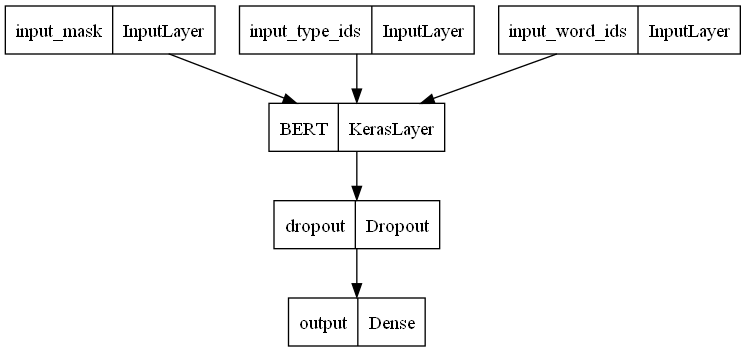

In [33]:
tf.keras.utils.plot_model(model)

In [36]:
def trainModel (epochsNumber,cycles):
    history=pd.DataFrame()
    for cycle in range(cycles):
     
        print(f'Cycle number: {cycle+1}')
        trainDataset,EvalDataset=createShuffledDatasets(NewProjectCorpus)

        checkpoint_path = "c:\\model\\"
        checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create a callback that saves the model's weights
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                save_weights_only=True,
                                                                verbose=1)

        #load the model from the checkpoint path
        #model.load_weights(checkpoint_path)

        #Tuning decay via Learning rate 
        def TuneLearningRate(epochsNumber,rate):
            if epoch < 6 :#or cycle < 0 :
                return rate
            else:
                return rate * tf.math.exp(-0.0001)

        #create callbcak for the learning rate scheduler
        scheduler = tf.keras.callbacks.LearningRateScheduler(TuneLearningRate)

        results=model.fit(trainDataset,
                    epochs=epochsNumber,
                    validation_data=EvalDataset,
                    #callbacks=[checkpoint_callback,scheduler]
                    callbacks=[checkpoint_callback]
                    )
        history=history.append(results.history, ignore_index=True)
    return history

In [37]:
results=trainModel(ProjConfig['epochs'], ProjConfig['cycles'])

Cycle number: 1
Epoch 1/6
1249/1250 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.4793
Epoch 1: saving model to c:\model\


In [ ]:
def plotResults(results):
    acc = results['accuracy']
    val_acc = results['val_accuracy']
    loss = results['loss']
    val_loss = results['val_loss']

    epochs_range = range(ProjConfig['epochs'])
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy',)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.suptitle('Learning rate: '+ str((ProjConfig['learning_rate']))+'\n'
                'Decay factor: '+ str((ProjConfig['decay_factor']))+'\n'
                'Max Sequence Length: '+ str((ProjConfig['max_seq_len']))+'\n' 
                'cycle: '+ str((results.name))+'\n' +'\n')
                
   
    plt.title('\n' +'Training and Validation Accuracy')
    plt.subplot(1, 2, 2)

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')

    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:

results

In [ ]:
results_lists = results[['loss','accuracy','val_loss','val_accuracy']].unstack().apply(pd.Series)

In [ ]:
results_lists[1].name

In [ ]:
for cycle in results_lists.columns:
    plotResults(results_lists[cycle])

In [ ]:
Predictions =model.predict(testDataset)
PredictionsList=[]
PredictionsList.append(Predictions)

testPredictions=test
testPredictions['predictions']=PredictionsList[0]
testPredictions['predictionsRounded']=testPredictions['predictions'].apply(round)

In [ ]:
class_likelihood_ratios(testPredictions['author'],testPredictions['predictionsRounded'],labels=(0,1))


In [ ]:
testPredictions.loc[testPredictions['author'] == testPredictions['predictionsRounded']].play.value_counts()#

In [ ]:
testPredictions.loc[testPredictions['author'] != testPredictions['predictionsRounded']].play.value_counts()#

In [ ]:
def cleanShakespeareText(filePath):
    with open(filePath) as file:
        lines = file.readlines()
        file.close()
    text=[]

    for line in lines:
        if line =='\n':
            continue
        
        line=clean.removeSpeakerName(line) #remove speaker's name from  each line
        line=clean.removeLinesBasedOnWords(['ACT', 'SCENE'],line) # removing lines with the words ACTS and Scenes
        line=clean.removeWords(['1','2','3','4','5','6','7','8','9'],line)
        line=clean.removeLinesBasedOnWords(['Exit'],line)
        line=clean.removeLinesBasedOnWords(['Enter'],line)
        line=clean.remove_words_in_brackets(line)
        line=clean.removeWhitespace(line)
        text.append(line)
    return text    

In [ ]:
def cleanFilesinPath(playPath,cleanFilesPath):
    for play in os.scandir(playPath):
        if play.is_file():
            print((" cleaning  ") + (play.name))
            cleanedPlay=cleanShakespeareText(play.path)
            
            with open(cleanFilesPath+play.name.removesuffix('.txt')+'Cleaned'+'.txt', 'w') as cleanedFile:
                cleanedFile.write("\n".join(str(item) for item in cleanedPlay))
                

In [ ]:
OriginalShakespearePath='./Corpus/UnseenTexts/Shakespeare/'
CleanShakespearePath='./Corpus/UnseenTexts/Shakespeare/CleanedPlays/'
cleanFilesinPath(OriginalShakespearePath,CleanShakespearePath)


In [ ]:
def importPlaysinCorpus(CorpusPath,Author):
    corpus=pd.DataFrame()
    for play in os.scandir(CorpusPath):
        if play.is_file():
            print((" importing  ") + (play.path) + (" to corpus"))
            newplay=pd.read_csv(play.path, delimiter='\r', header=None, names=['sentence', 'author', 'play'])
            newplay[['author']]=Author
            if 'Cleaned' in play.path:
                newplay[['play']]=os.path.basename(play.path).removesuffix('Cleaned.txt')
            else:
                newplay[['play']]=os.path.basename(play.path).removesuffix('.txt')
            corpus=pd.concat([corpus, newplay], axis = 0,join='outer')
    return corpus


In [ ]:
ShakespeareUnseenPath='./Corpus/UnseenTexts/Shakespeare/CleanedPlays/'
MarloweUnseenPath='./Corpus/UnseenTexts/Marlowe/'
ShakespeareUnseen=pd.DataFrame()

ShakespeareUnseen=importPlaysinCorpus(ShakespeareUnseenPath,'Shakespeare')
ShakespeareUnseen['sentence']=ShakespeareUnseen['sentence'].str.lower()

MarloweUnseen=importPlaysinCorpus(MarloweUnseenPath,'Marlowe')
MarloweUnseen['sentence']=MarloweUnseen['sentence'].str.lower()
Unseen=pd.DataFrame()
Unseen=pd.concat([Unseen,MarloweUnseen],axis=0, join="outer")
Unseen=pd.concat([Unseen,ShakespeareUnseen],axis=0, join="outer")
#shuffling line in the dataframe
Unseen=Unseen.sample(frac = 1)
#replacing the author with 0 for Marlowe and 1 for Shakespeare
Unseen['author'].replace(['Marlowe','Shakespeare'],[0,1],inplace=True)

In [ ]:

UnseenDataset=createDataset(Unseen,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
Predictions =model.predict(UnseenDataset)
PredictionsList=[]
PredictionsList.append(Predictions)


Unseen['predictions']=PredictionsList[0]
Unseen['predictionsRounded']=Unseen['predictions'].apply(round)

In [ ]:
Unseen

In [ ]:
PredictionsStats=[]
PredictionsStats=Unseen.loc[Unseen['author'] != Unseen['predictionsRounded']].play.value_counts()
PredictionsStats.columns=['author','Not Correct']
PredictionsStats=PredictionsStats.to_frame(name='Not Correct')
PredictionsStats['Correct']=Unseen.loc[Unseen['author'] == Unseen['predictionsRounded']].play.value_counts()
PredictionsStats['Accuracy']=PredictionsStats['Correct']/(PredictionsStats['Correct']+PredictionsStats['Not Correct'])
PredictionsStats

In [ ]:
class_likelihood_ratios(Unseen['author'],Unseen['predictionsRounded'],labels=(0,1))